In [11]:
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda:0


In [12]:
X_dim = 6
c_dim = 21
gridSize = 100
z_dim = 5

bs = 256

In [35]:
import torch.nn.functional as F
   
class AttentionVAE(nn.Module):
    def __init__(self, sample_size, grid_size, cond_size, encoder_layer_sizes, latent_size, decoder_layer_sizes):
        super(AttentionVAE, self).__init__()

        assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list
        
        self.latent_size = latent_size
        self.condNN = CondNN(sample_size, grid_size, cond_size)
        self.encoder = Encoder(sample_size + cond_size, encoder_layer_sizes, latent_size)
        self.decoder = Decoder(latent_size + cond_size, decoder_layer_sizes, sample_size)

    def condnn(self,startend, occ):
        return self.condNN(startend, occ)
        
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

#     @torch.jit.export
    def forward(self, x, startend, occ):
        c, _ = self.condnn(startend, occ)
        mu, logvar = self.encode(torch.cat((x, c), dim=-1))
        z = self.reparameterize(mu, logvar)
        self.inference(startend, occ, torch.tensor(1))
        return self.decode(torch.cat((z, c), dim=-1)), mu, logvar
    
    def inference(self, startend, occ, num_viz):
        c, alpha = self.condnn(startend, occ)
        z = torch.randn(num_viz, self.latent_size, device = c.device)
        return self.decode(torch.cat((z, c), dim=-1)), alpha
    
class Encoder(nn.Module):
    def __init__(self, input_size, layer_sizes, latent_size):
        super(Encoder, self).__init__()

        layer_sizes = [input_size] + layer_sizes
        modules = []
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.ReLU())
#             modules.append(nn.Dropout(p=0.5))

        self.sequential = nn.Sequential(*modules)
        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x):
        x = self.sequential(x)
        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)
        return means, log_vars


class Decoder(nn.Module):
    def __init__(self, input_size, layer_sizes, sample_size):
        super(Decoder, self).__init__()

        layer_sizes = [input_size] + layer_sizes
        modules = []
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.ReLU())
#             modules.append(nn.Dropout(p=0.5))
        modules.append(nn.Linear(layer_sizes[-1], sample_size))
        
        self.sequential = nn.Sequential(*modules)

    def forward(self, x):
        return self.sequential(x)


class CondNN(nn.Module):
    def __init__(self, sampleSize, gridSize, outSize, encoder_dim=48, condition_dim=12, attention_dim=48):
        super(CondNN, self).__init__()
        self.CnnEncoder = CnnEncoder(gridSize)
        self.Attention = Attention(encoder_dim + 2, condition_dim, attention_dim) # + 2 for position
        self.fc1 = nn.Linear(attention_dim + 2 + condition_dim, outSize)

    def forward(self, startend, occ):
        encoder_out = self.CnnEncoder(occ)
        attention_weighted_encoding, alpha = self.Attention(encoder_out, startend)
        x = torch.cat((attention_weighted_encoding, startend), dim=-1)
        x = self.fc1(x)
        return x, alpha

class CnnEncoder(nn.Module):
    def __init__(self, gridSize, encoded_image_size=11):
        super(CnnEncoder, self).__init__()
        self.gridSize = gridSize
        self.encoded_image_size = encoded_image_size
        self.cnn = nn.Sequential(
                    nn.Conv2d(1, 6, 5, padding=(2,2)),
                    nn.MaxPool2d(3,3),
                    nn.Conv2d(6, 16, 5, padding=(2,2)),
                    nn.MaxPool2d(2,2),
                    nn.Conv2d(16, 48, 5, padding=(2,2)),
                    nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size)))
            
    def forward(self, images):
        out = self.cnn(images)
        out = out.permute(0, 2, 3, 1) # (batch_size, encoded_image_size, encoded_image_size, 48)
        return out
            
class Attention(nn.Module):
    def __init__(self, encoder_dim, condition_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.condition_att = nn.Linear(condition_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.position = self.initPosition()
    
    def initPosition(self):
        x = np.linspace(0, 10, 11, dtype='float32')
        y = np.linspace(0, 10, 11, dtype='float32')
        xv, yv = np.meshgrid(x,y)
        xv, yv = xv.reshape((1,-1, 1)), yv.reshape((1,-1, 1))
        position = torch.from_numpy(np.concatenate((xv, yv), axis = 2))
        
        return position
        
        
    def forward(self, encoder_out, condition):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        self.position = self.position.to(encoder_out.device)
        self.position = self.position.expand(batch_size, self.position.shape[1], self.position.shape[2])
        encoder_out = torch.cat((encoder_out, self.position), dim = 2)
        
        att1 = self.encoder_att(encoder_out)
        att2 = self.condition_att(condition)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
            
        return attention_weighted_encoding, alpha

In [36]:
torch.cuda.empty_cache()

model = AttentionVAE(sample_size = X_dim, 
                  grid_size = gridSize, 
                  cond_size = 21,
                  encoder_layer_sizes = [512,1024,512], 
                  latent_size = z_dim, 
                  decoder_layer_sizes = [512,1024,512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

checkpoint = torch.load('checkpoints/attention.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

model.eval()

AttentionVAE(
  (condNN): CondNN(
    (CnnEncoder): CnnEncoder(
      (cnn): Sequential(
        (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(16, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (5): AdaptiveAvgPool2d(output_size=(11, 11))
      )
    )
    (Attention): Attention(
      (encoder_att): Linear(in_features=50, out_features=48, bias=True)
      (condition_att): Linear(in_features=12, out_features=48, bias=True)
      (full_att): Linear(in_features=48, out_features=1, bias=True)
      (relu): ReLU()
      (softmax): Softmax(dim=1)
    )
    (fc1): Linear(in_features=62, out_features=21, bias=True)
  )
  (encoder): Encoder(
    (sequential): Sequential(
      (0): Line

In [37]:
from data.AttentionDataset import AttentionDataset

test_loader = DataLoader(AttentionDataset(np_file_data = 'data/NarrowPassage/narrowDataOcc100.npz',
                            sample_dim = X_dim, 
                            condition_dim = c_dim,
                            gridSize = gridSize,
                            train = False),
                          batch_size = bs, shuffle=True, drop_last = True)

8712


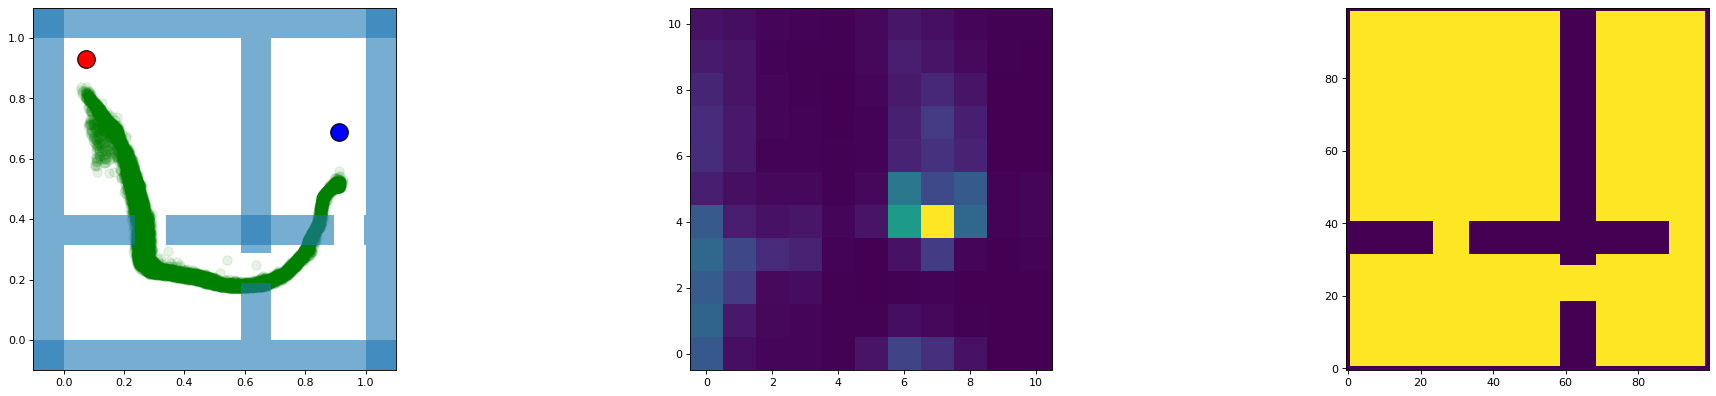

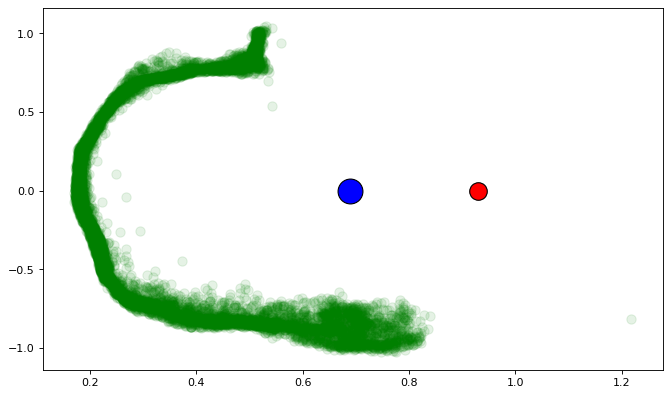

In [38]:
test_data = test_loader.dataset
viz_idx =   torch.randint(0,len(test_data),[1]).item()  
viz_idx = 8712
print(viz_idx)

_, con, startend, occ = test_data[viz_idx]
startend, occ = torch.tensor(startend), torch.unsqueeze(torch.tensor(occ), 0)

model.eval()
y_viz = torch.randn(1,6).to(device)
with torch.no_grad():
    for i in range(0, 40):
        num_viz = 256
        y_viz_p, alpha = model.inference(startend.expand(num_viz, X_dim * 2).to(device), 
                                occ.expand(num_viz, 1, gridSize, gridSize).to(device), num_viz)
        torch.cuda.empty_cache()
        y_viz = torch.cat((y_viz_p, y_viz), dim = 0)

y_viz=y_viz.cpu().detach().numpy()
occ=occ.cpu().detach().numpy()

from utils.NarrowPassage import plotCondition, plotSample, plotSpeed, plotSampleAttention, gap2obs

torch.cuda.empty_cache()

startend = startend.cpu().detach().numpy()
occ = occ[0].reshape(100,100)
a = alpha[0].reshape(11,11)
a = a.cpu().detach().numpy()

plotSampleAttention(y_viz, con, occ, a)
plotSpeed(y_viz, con)

In [7]:
def con2obs(con):
    dw = 0.1
    dimW = 3
    gap1 = con[0:3]
    gap2 = con[3:6]
    gap3 = con[6:9]

    obs1 = [0, gap1[1] - dw, -0.5, gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0] - dw, 0, -0.5, gap2[0], gap2[1], 1.5]
    obs3 = [gap2[0] - dw, gap2[1] + dw, -0.5, gap2[0], 1, 1.5]
    obs4 = [gap1[0] + dw, gap1[1] - dw, -0.5, gap3[0], gap1[1], 1.5]
    obs5 = [gap3[0] + dw, gap1[1] - dw, -0.5, 1, gap1[1], 1.5]
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    return obs, dimW

import matplotlib.patches as patches
def pltObs(obs, dimW):
    fig1 = plt.figure(figsize=(30, 6), dpi=80)
    ax1 = fig1.add_subplot(131, aspect='equal')
    for i in range(0, obs.shape[0] // (2 * dimW)):  # plot obstacle patches
        ax1.add_patch(
            patches.Rectangle(
                (obs[i * 2 * dimW], obs[i * 2 * dimW + 1]),  # (x,y)
                obs[i * 2 * dimW + dimW] - obs[i * 2 * dimW],  # width
                obs[i * 2 * dimW + dimW + 1] - obs[i * 2 * dimW + 1],  # height
                alpha=0.6
            ))
    plt.show()

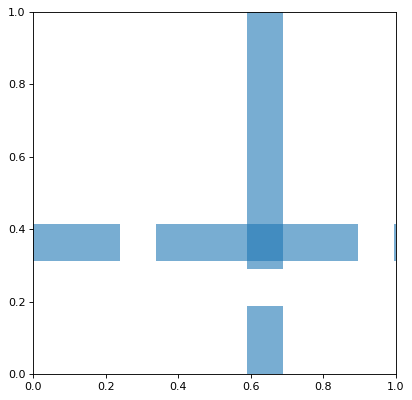

In [8]:
obs, dimW = con2obs(con)
pltObs(obs, dimW)

In [9]:
import fcl

def obs2fcl(obs, dimW):
    obs_fcl = []
    for i in range(0, obs.shape[0] // (2 * dimW)):  # plot obstacle patches
        width = obs[i * 2 * dimW + dimW] - obs[i * 2 * dimW]
        height = obs[i * 2 * dimW + dimW + 1] - obs[i * 2 * dimW + 1]
    #     width = height = 1
        ob = fcl.Box(width, height, 1)
        x = obs[i * 2 * dimW] + width/2
        y = obs[i * 2 * dimW + 1] + height/2
    #     x = y = 0
        T = np.array([x, y, 0])
        t = fcl.Transform(T)
        co = fcl.CollisionObject(ob, t)
        obs_fcl.append(co)
#         print("x: ", x, " y: ", y, " width: ", width, " height: ", height)

    obs_manager = fcl.DynamicAABBTreeCollisionManager()
    obs_manager.registerObjects(obs_fcl)
    obs_manager.setup()
    return obs_manager

In [10]:
import sys
try:
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
except ImportError:
    # if the ompl module is not in the PYTHONPATH assume it is installed in a
    # subdirectory of the parent directory called "py-bindings."
    from os.path import abspath, dirname, join
    sys.path.insert(0, join(dirname(dirname(abspath(__file__))), 'py-bindings'))
    from ompl import util as ou
    from ompl import base as ob
    from ompl import geometric as og
from math import sqrt
import argparse

# Keep these in alphabetical order and all lower case
def allocatePlanner(si, plannerType):
    if plannerType.lower() == "bfmtstar":
        return og.BFMT(si)
    elif plannerType.lower() == "bitstar":
        return og.BITstar(si)
    elif plannerType.lower() == "fmtstar":
        return og.FMT(si)
    elif plannerType.lower() == "informedrrtstar":
        return og.InformedRRTstar(si)
    elif plannerType.lower() == "prmstar":
        return og.PRMstar(si)
    elif plannerType.lower() == "rrtstar":
        return og.RRTstar(si)
    elif plannerType.lower() == "sorrtstar":
        return og.SORRTstar(si)
    else:
        ou.OMPL_ERROR("Planner-type is not implemented in allocation function.")

In [545]:
class MyValidStateSampler(ob.ValidStateSampler):
    def __init__(self, si, cvae_samples):
        super(MyValidStateSampler, self).__init__(si)
        print("called")
        self.name_ = "my sampler"
        self.cvae_samples = cvae_samples
        self.cvae_num = cvae_samples.shape[0]
        print("cvae_num", self.cvae_num)
        self.i = 0
        self.random_count = 0
        self.rng_ = ou.RNG()
        
#     def __call__(self, i): 
#         return self
        
    def sample(self, state):
        chance = self.rng_.uniformReal(0, 1)
#         print("sample")
        
        if chance < 0.5:
            x = self.cvae_samples[self.i, 0]
            y = self.cvae_samples[self.i, 1]
            self. i += 1
            if self.i == self.cvae_num:
                self.i = 0
            print("cvae: ", self.i)
        else:
            x = self.rng_.uniformReal(0, 1)
            y = self.rng_.uniformReal(0, 1)
            self.random_count += 1
            print("random: ", self.random_count)
        state.setX(float(x))
        state.setY(float(y))
        return True
# return an instance of my sampler
def allocMyValidStateSampler(si):
    return MyValidStateSampler(si, y_viz)

class ValidityChecker(ob.StateValidityChecker):
    def __init__(self,  si, fcl_manager, space):
        super(ValidityChecker, self).__init__(si)
        self.space = space
        self.fcl_manager = fcl_manager
        self.count = 0
        self.collision_count = 0
        self.states_ok = []
        self.states_bad = []
        # Returns whether the given state's position overlaps the
        # circular obstacle
    def isValid(self, state):
        sample = np.array([state.getX(), state.getY(), 0])
#         sample = np.array([state().getX(), state().getY(), state().getYaw()])
        req = fcl.CollisionRequest(num_max_contacts=100, enable_contact=True)
        rdata = fcl.CollisionData(request = req)

        cyl = fcl.Cylinder(0.01, 2)
        t = fcl.Transform(sample)
        agent = fcl.CollisionObject(cyl, t)

        self.fcl_manager.collide(agent, rdata, fcl.defaultCollisionCallback)
#         if(rdata.result.is_collision):
#             print("state: ", sample, " collision: ", rdata.result.is_collision)
#         print ('Collision between manager 1 and agent?: {}'.format(rdata.result.is_collision))
#         print( 'Contacts:')
#         for c in rdata.result.contacts:
#             print( '\tO1: {}, O2: {}'.format(c.o1, c.o2))
        self.count += 1
        if(rdata.result.is_collision):
            self.collision_count += 1
#             self.states_bad.append(sample)
#         else:
#             self.states_ok.append(sample)
        return not rdata.result.is_collision

In [558]:
space = ob.SE2StateSpace()
# set lower and upper bounds
bounds = ob.RealVectorBounds(2)
bounds.setLow(0)
bounds.setHigh(1)
space.setBounds(bounds)
# construct an instance of space information from this state space
si = ob.SpaceInformation(space)
# set state validity checking for this space
obs_manager = obs2fcl(obs, dimW)
mychecker = ValidityChecker(si, obs_manager, space)
si.setStateValidityChecker(mychecker)

si.setStateValidityCheckingResolution(0.01)
# si.setup()
# create a random start state
start = ob.State(space)
start.random()
start().setX(float(startend[0]))
start().setY(float(startend[1]))
# create a random goal state
goal = ob.State(space)
goal.random()
goal().setX(float(startend[6]))
goal().setY(float(startend[7]))
# create a problem instance
pdef = ob.ProblemDefinition(si)
pdef.setOptimizationObjective(ob.PathLengthOptimizationObjective(si))
# set the start and goal states
pdef.setStartAndGoalStates(start, goal)
si.setValidStateSamplerAllocator (ob.ValidStateSamplerAllocator(allocMyValidStateSampler))
# create a planner for the defined space
optimizingPlanner = allocatePlanner(si, 'prmstar')
# planner = og.RRTConnect(si)
# set the problem we are trying to solve for the planner
optimizingPlanner.setProblemDefinition(pdef)
# perform setup steps for the planner
optimizingPlanner.setup()

# print the settings for this space
# print(si.settings())
# print the problem settings
# print(pdef)
# attempt to solve the problem within one second of planning time
solved = optimizingPlanner.solve(20)
print("collision detection: ", mychecker.count)
print("collision num: ", mychecker.collision_count)
if solved:
    # get the goal representation from the problem definition (not the same as the goal state)
    # and inquire about the found path
    path = pdef.getSolutionPath()
    if path:
        print("path length: ", pdef.getSolutionPath().length())
#     print("Found solution:\n%s" % path)
else:
    print("No solution found")

called
cvae_num 10241
random:  1
cvae:  1
cvae:  2
random:  2
random:  3
cvae:  3
random:  4
cvae:  4
cvae:  5
random:  5
random:  6
random:  7
cvae:  6
cvae:  7
random:  8
cvae:  8
cvae:  9
cvae:  10
random:  9
random:  10
random:  11
random:  12
random:  13
random:  14
cvae:  11
random:  15
random:  16
cvae:  12
random:  17
cvae:  13
random:  18
cvae:  14
cvae:  15
cvae:  16
random:  19
random:  20
random:  21
cvae:  17
cvae:  18
cvae:  19
cvae:  20
cvae:  21
cvae:  22
cvae:  23
random:  22
random:  23
random:  24
random:  25
cvae:  24
random:  26
cvae:  25
random:  27
random:  28
cvae:  26
random:  29
random:  30
cvae:  27
cvae:  28
random:  31
cvae:  29
random:  32
cvae:  30
cvae:  31
cvae:  32
cvae:  33
random:  33
cvae:  34
cvae:  35
random:  34
random:  35
random:  36
cvae:  36
cvae:  37
random:  37
cvae:  38
cvae:  39
random:  38
random:  39
random:  40
cvae:  40
random:  41
random:  42
random:  43
random:  44
random:  45
random:  46
random:  47
random:  48
cvae:  41
random:  4

In [559]:
from utils.NarrowPassage import gap2obs
def plt_ompl_result(condition, start, goal, path, collisionchecker):
    fig1 = plt.figure(figsize=(10, 6), dpi=80)
    ax1 = fig1.add_subplot(111, aspect='equal')
    obs, dimW = gap2obs(condition)
    for i in range(0, obs.shape[0] // (2 * dimW)):  # plot obstacle patches
        ax1.add_patch(
            patches.Rectangle(
                (obs[i * 2 * dimW], obs[i * 2 * dimW + 1]),  # (x,y)
                obs[i * 2 * dimW + dimW] - obs[i * 2 * dimW],  # width
                obs[i * 2 * dimW + dimW + 1] - obs[i * 2 * dimW + 1],  # height
                alpha=0.6
            ))
#         ax1.add_patch(
#             patches.Rectangle(
#                 (1-obs[i * 2 * dimW], obs[i * 2 * dimW + 1]),  # (x,y)
#                 obs[i * 2 * dimW + dimW] - obs[i * 2 * dimW],  # width
#                 obs[i * 2 * dimW + dimW + 1] - obs[i * 2 * dimW + 1],  # height
#                 alpha=0.6
#             ))
    gridSize = 11
    
    path.interpolate()
    states = path.getStates()
    for state in states:
        plt.scatter(state.getX(), state.getY(), color="green", s=250, edgecolors='black')  # path
#     for state in collisionchecker.states_ok:
#         plt.scatter(state[0], state[1], color="green", s=100, edgecolors='green')  # free sample
#     for state in collisionchecker.states_bad:
#         plt.scatter(state[0], state[1], color="red", s=100, edgecolors='red')  # collision sample
    plt.scatter(start().getX(), start().getY(), color="blue", s=250, edgecolors='black')  # init
    plt.scatter(goal().getX(), goal().getY(), color="red", s=250, edgecolors='black')  # goal
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [27]:
plt_ompl_result(con, start, goal,path, mychecker)

NameError: name 'plt_ompl_result' is not defined

In [28]:
sm = torch.jit.script(model)

In [29]:
sm.save("checkpoints/script_attention_model.pt")